In [2]:
import django, sys, os, random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

sys.path.append('/home/galm/software/django/tmv/BasicBrowser/')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()
from django.db.models import Q, F, Sum, Count, FloatField, Case, When, Value, Max
from scipy.sparse import coo_matrix, find
from sklearn.manifold import TSNE

from scoping.models import *
from tmv_app.models import *

import matplotlib
matplotlib.rcParams["figure.figsize"] = [7.2,4.5]
matplotlib.rcParams['axes.labelsize'] = 7 
matplotlib.rcParams['xtick.labelsize'] = 5
matplotlib.rcParams['ytick.labelsize'] = 5 

run_id = 662

In [8]:
db_matrix = DocDynamicTopic.objects.filter(run_id=run_id,score__gt=0.01)
docs = set(db_matrix.values_list('doc__id',flat=True))

len(docs)

289061

In [10]:
s_docs = random.sample(docs,20000)

In [11]:
column = 'term_id'
column = 'doc_id'

stat = RunStats.objects.get(pk=run_id)

db_matrix = DocTopic.objects.filter(
    run_id=run_id,
    score__gt=0.01,
    doc__id__in=s_docs
)



from scipy.sparse import *

vs = list(db_matrix.values('score',column,'topic_id'))

c_ind = np.array(db_matrix.values_list(column,flat=True).order_by(column).distinct())
r_ind = np.array(db_matrix.values_list('topic_id',flat=True).order_by('topic_id').distinct())

d = [x['score'] for x in vs]


c = [int(np.where(c_ind==x[column])[0]) for x in vs]
r = [int(np.where(r_ind==x['topic_id'])[0]) for x in vs]

m = csr_matrix((d,(r,c)),shape=(len(r_ind),len(c_ind)))

m = csr_matrix((d,(c,r)),shape=(len(c_ind),len(r_ind)))

print(db_matrix.count())

71038


In [12]:
tsne = TSNE(n_components=2, verbose=1, perplexity=50)
tsne_results = tsne.fit_transform(m.toarray())

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 19595 samples in 5.815s...
[t-SNE] Computed neighbors for 19595 samples in 404.344s...
[t-SNE] Computed conditional probabilities for sample 1000 / 19595
[t-SNE] Computed conditional probabilities for sample 2000 / 19595
[t-SNE] Computed conditional probabilities for sample 3000 / 19595
[t-SNE] Computed conditional probabilities for sample 4000 / 19595
[t-SNE] Computed conditional probabilities for sample 5000 / 19595
[t-SNE] Computed conditional probabilities for sample 6000 / 19595
[t-SNE] Computed conditional probabilities for sample 7000 / 19595
[t-SNE] Computed conditional probabilities for sample 8000 / 19595
[t-SNE] Computed conditional probabilities for sample 9000 / 19595
[t-SNE] Computed conditional probabilities for sample 10000 / 19595
[t-SNE] Computed conditional probabilities for sample 11000 / 19595
[t-SNE] Computed conditional probabilities for sample 12000 / 19595
[t-SNE] Computed conditional probabilities for 

## Urban (blue), and Buildings (red) are close together 

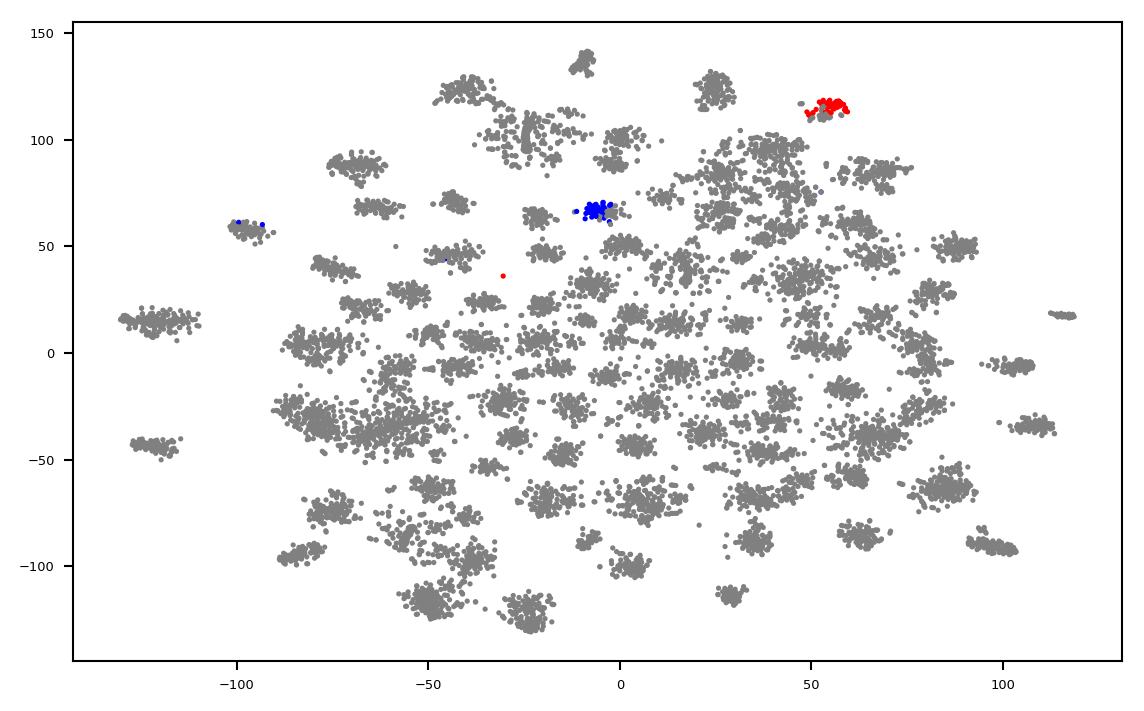

In [26]:


cmap = {
    1: "#66c2a5",
    2: "#fc8d62",
    3: "#8da0cb"
}

cs = []
sizes = []
xs = []
ys = []


fig = plt.figure(dpi=188)

build = list(DocTopic.objects.filter(
    topic__id=125029,doc__id__in=s_docs
).order_by('-score')[:50].values_list('doc__id',flat=True))

urban = list(DocTopic.objects.filter(
    topic__id=124998,doc__id__in=s_docs
).order_by('-score')[:50].values_list('doc__id',flat=True))

ubs = list(DocTopic.objects.filter(
    topic__id=124998,doc__id__in=s_docs
).order_by('-score')[:50].values_list('doc__id',flat=True))


#for i,t in enumerate(Doc.objects.filter(id__in=c_ind)):
for i,did in enumerate(c_ind):
    x = tsne_results[i,0]
    y = tsne_results[i,1]
    #if x > -7 and x < -5 and y > 4 and y < 6:
    if x>-10000000:
        #if hasattr(t,'wosarticle'):
        #    if t.wosarticle.tc is not None:
        #        if t.wosarticle.tc > 5000:
        #            plt.text(x,y,t.title,fontsize=5)
        #plt.text(x,y,t.title,fontsize=7)
        if did in build:
            cs.append("red")
        elif did in urban:
            cs.append("blue")
        else:
            cs.append("grey")
        #cs.append(cmap[t.primary_wg])
        #sizes.append(t.score)
        xs.append(x)
        ys.append(y)

plt.scatter(
    xs,
    ys,
    s=1,
    #s=sizes,
    c=cs,
)
plt.show()

## Clusters are mixtures of disciplines, but disciplines congregate in broad areas of the graph

This indicates that the distance **between** clusters is also telling us something interesting

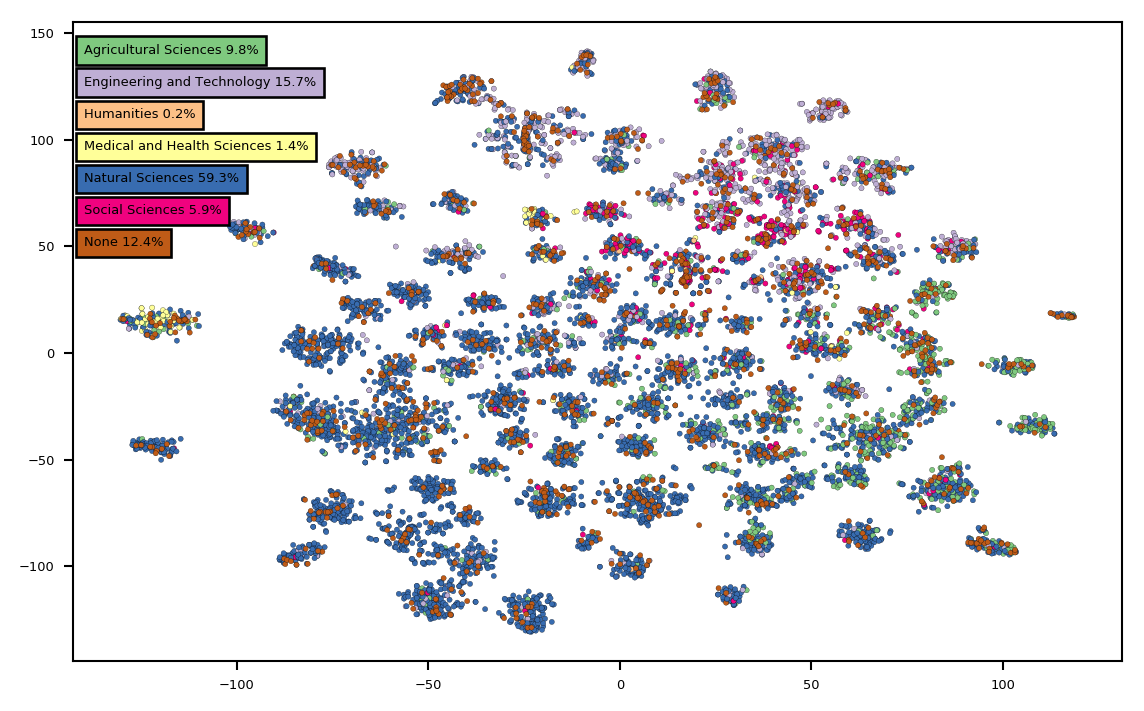

In [52]:
cs = []
sizes = []
xs = []
ys = []


fig = plt.figure(dpi=188)

colors = ['#b3e2cd','#fdcdac','#cbd5e8','#f4cae4','#e6f5c9','#fff2ae']
colors = ['#b3e2cd','#fdcdac','#cbd5e8','#f4cae4','#e6f5c9','#fff2ae','#f1e2cc']
colors = ['#7fc97f','#beaed4','#fdc086','#ffff99','#386cb0','#f0027f','#bf5b17']
oecd_cats = list(Doc.objects.filter(id__in=s_docs).distinct('wc__oecd').values('wc__oecd'))
for i,c in enumerate(oecd_cats):
    c['docs'] = list(Doc.objects.filter(id__in=s_docs,wc__oecd=c['wc__oecd']).values_list('id',flat=True))
    c['color'] = colors[i]


#for i,t in enumerate(Doc.objects.filter(id__in=c_ind)):
for i,did in enumerate(c_ind):
    x = tsne_results[i,0]
    y = tsne_results[i,1]
    col = "grey"
    for c in oecd_cats:
        if did in c['docs']:
            col = c['color']
    cs.append(col)
    xs.append(x)
    ys.append(y)
        

plt.scatter(
    xs,
    ys,
    s=4,
    #s=sizes,
    linewidth=0.1,
    c=cs,
    edgecolor='k'
)
for i,c in enumerate(oecd_cats):
    plt.text(
        -140,
        140-i*15,
        "{} {:.1%}".format(c['wc__oecd'],len(c['docs'])/10000),
        fontsize=5,
        bbox={
            'facecolor': c['color'],
            'pad': 3
        }
    )
plt.show()

## Not many documents in the sample were cited by IPCC, but they reinforce the story suggested by the graph above

(note that this sample will contain a large proportion of documents written since the last report)

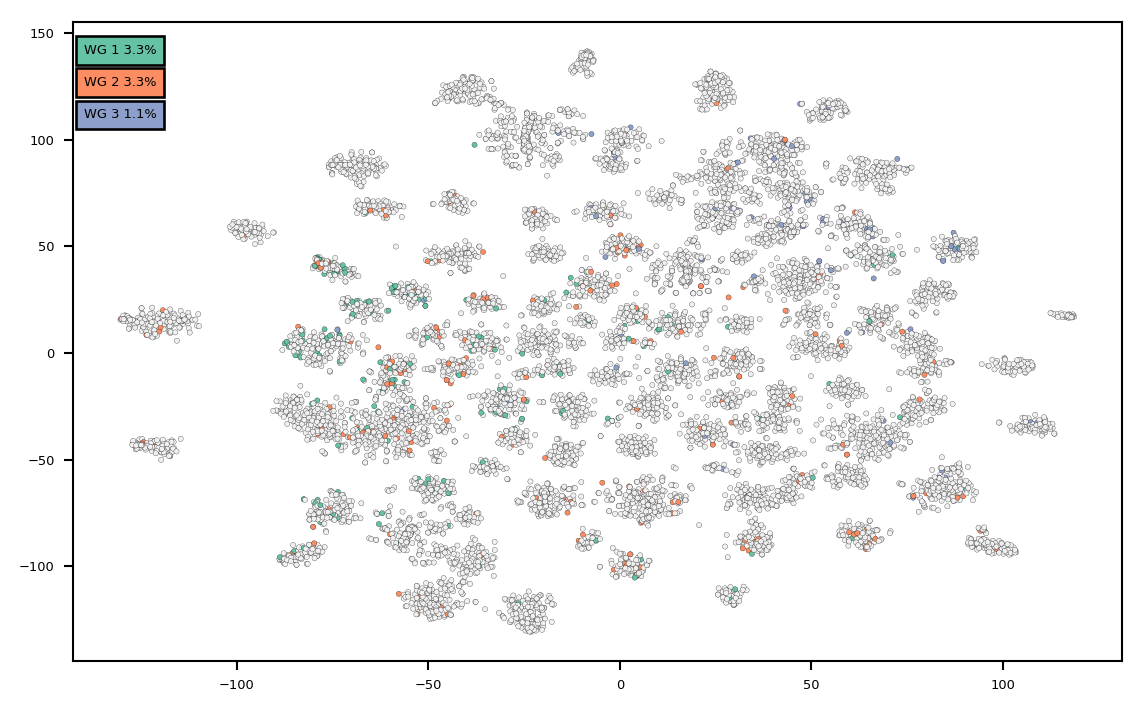

In [64]:
colors=["#66c2a5","#fc8d62","#8da0cb"]

cs = []
sizes = []
xs = []
ys = []
fig = plt.figure(dpi=188)

wgs = list(scoping.models.WG.objects.all().distinct('wg').values('wg'))
for i,c in enumerate(wgs):
    c['docs'] = list(Doc.objects.filter(
        id__in=s_docs,ipccref__wg__wg=c['wg']
    ).values_list('id',flat=True))
    c['color'] = colors[i]

    
for i,did in enumerate(c_ind):
    x = tsne_results[i,0]
    y = tsne_results[i,1]
    col = "#F0F0F0"
    for c in wgs:
        if did in c['docs']:
            col = c['color']
    cs.append(col)
    xs.append(x)
    ys.append(y)
        

plt.scatter(
    xs,
    ys,
    s=4,
    #s=sizes,
    linewidth=0.1,
    c=cs,
    edgecolor='k'
)
for i,c in enumerate(wgs):
    plt.text(
        -140,
        140-i*15,
        "WG {} {:.1%}".format(c['wg'],len(c['docs'])/10000),
        fontsize=5,
        bbox={
            'facecolor': c['color'],
            'pad': 3
        }
    )
plt.show()

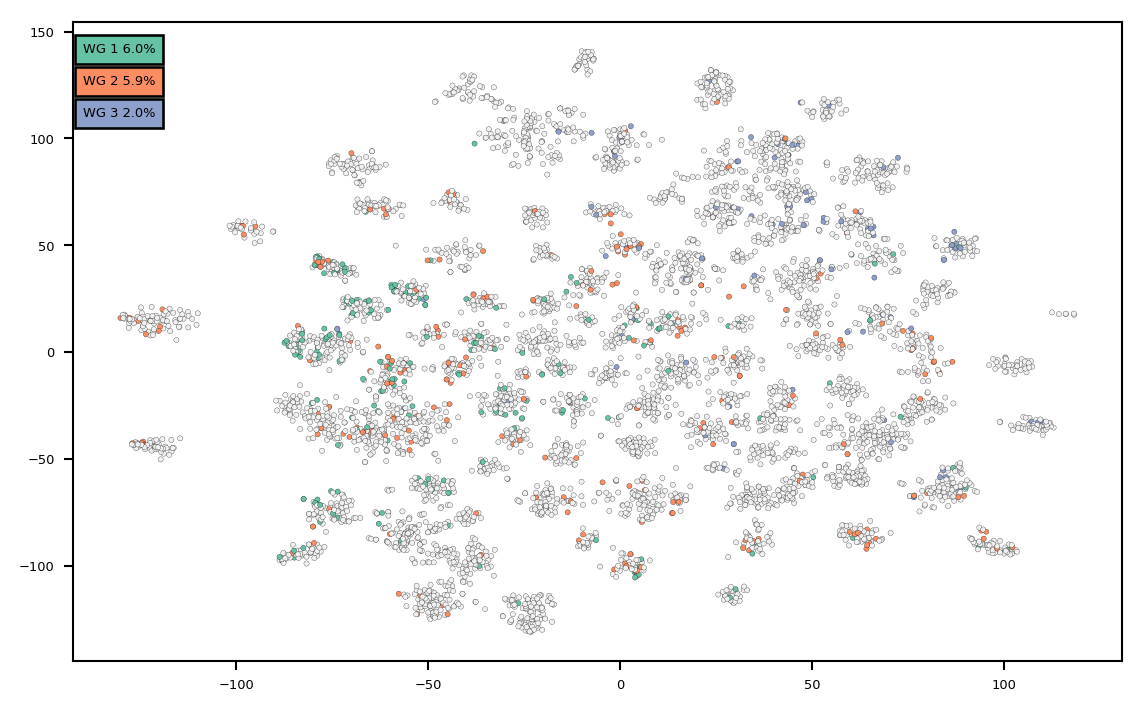

In [91]:
colors=["#66c2a5","#fc8d62","#8da0cb"]

cs = []
sizes = []
xs = []
ys = []
fig = plt.figure(dpi=188)

wgs = list(scoping.models.WG.objects.all().distinct('wg').values('wg'))
for i,c in enumerate(wgs):
    c['docs'] = list(Doc.objects.filter(
        id__in=s_docs,ipccref__wg__wg=c['wg']
    ).values_list('id',flat=True))
    c['color'] = colors[i]

post_ar5 = list(Doc.objects.filter(
        id__in=s_docs,PY__gt=2013
).values_list('id',flat=True))

ldocs = 0
for i,did in enumerate(c_ind):
    x = tsne_results[i,0]
    y = tsne_results[i,1]
    col = "#F0F0F0"
    for c in wgs:
        if did in c['docs']:
            col = c['color']
    if did not in post_ar5:
        cs.append(col)
        xs.append(x)
        ys.append(y)
        ldocs+=1

plt.scatter(
    xs,
    ys,
    s=4,
    #s=sizes,
    linewidth=0.1,
    c=cs,
    edgecolor='k'
)
for i,c in enumerate(wgs):
    plt.text(
        -140,
        140-i*15,
        "WG {} {:.1%}".format(c['wg'],len(c['docs'])/ldocs),
        fontsize=5,
        bbox={
            'facecolor': c['color'],
            'pad': 3
        }
    )
plt.show()

(1990, 2017)


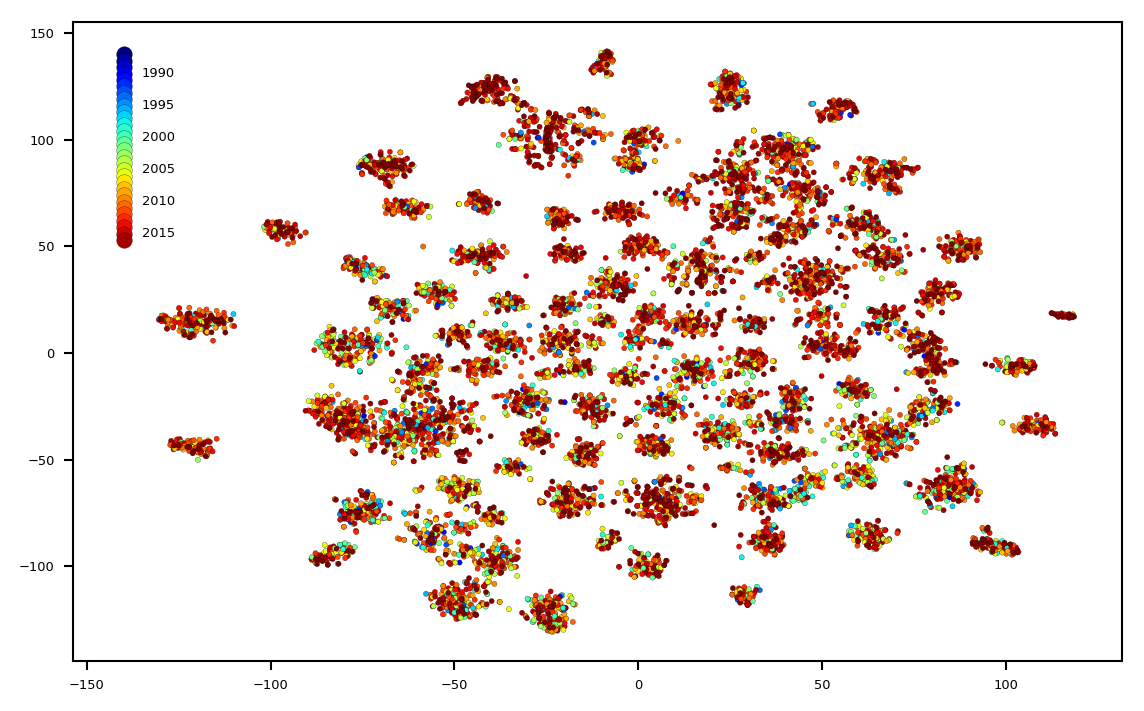

In [90]:
cs = []
sizes = []
xs = []
ys = []
fig = plt.figure(dpi=188)

years = list(Doc.objects.filter(
    id__in=s_docs
).values_list('PY',flat=True))

import matplotlib.colors as colors
import matplotlib.cm as cmx
jet = cm = plt.get_cmap('jet') 
cNorm  = colors.Normalize(vmin=min(years), vmax=max(years))
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)

scalarMap.to_rgba(1995)

for i,did in enumerate(c_ind):
    x = tsne_results[i,0]
    y = tsne_results[i,1]
    col = scalarMap.to_rgba(years[i])
    cs.append(col)
    xs.append(x)
    ys.append(y)
        

plt.scatter(
    xs,
    ys,
    s=4,
    #s=sizes,
    linewidth=0.1,
    c=cs,
    edgecolor='k'
)

i = 0
for y in range(scalarMap.get_clim()[0],scalarMap.get_clim()[1]):
    plt.scatter(
        -140,
        140-i*3,
        c=scalarMap.to_rgba(y),
        linewidth=0.1,
        edgecolor='k'
        
    )
    if y % 5 == 0:
        plt.text(
            -135,
            140-i*3,
            y,
            fontsize=5,
            va="center"
        )
    i+=1


plt.show()


In [126]:
from sklearn.cluster import DBSCAN
db = DBSCAN(eps=3).fit(tsne_results)

labels = db.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)


print('Estimated number of clusters: %d' % n_clusters_)

Estimated number of clusters: 86


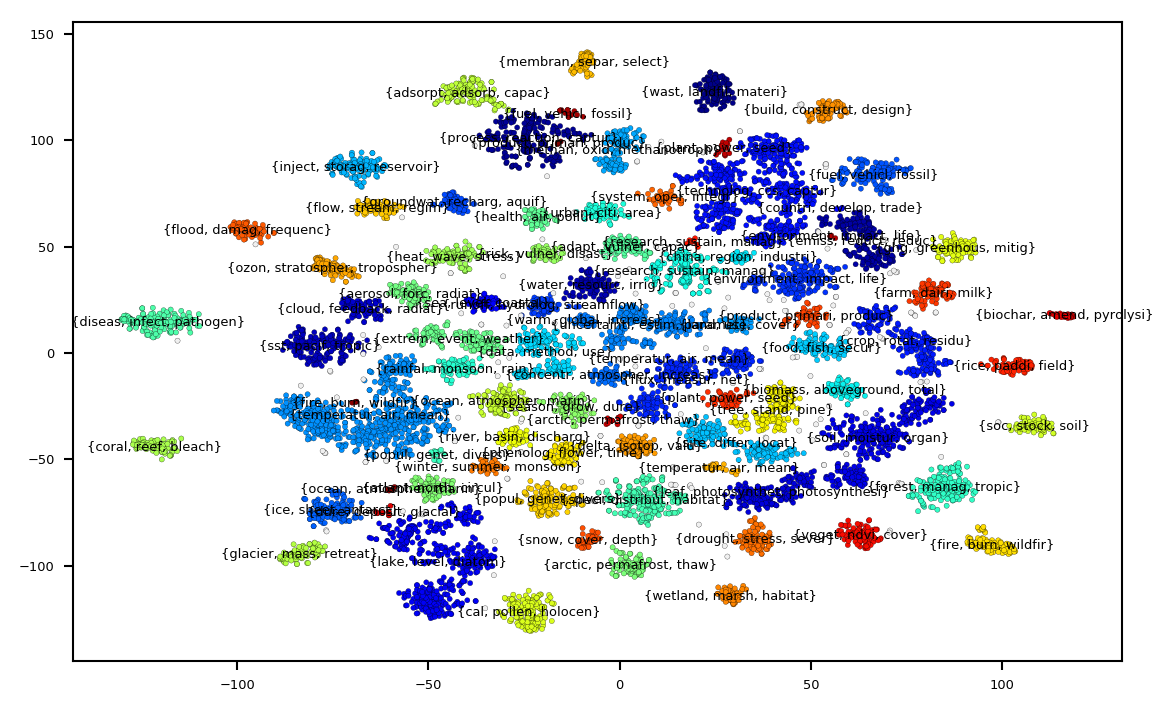

In [135]:
label_set = list(set(labels))

fig = plt.figure(dpi=188)

import matplotlib.colors as colors
import matplotlib.cm as cmx
jet = cm = plt.get_cmap('jet') 
cNorm  = colors.Normalize(vmin=min(label_set), vmax=max(label_set))
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)

for l in set(labels):
    ind = np.argwhere(labels==l)
    cs = []
    sizes = []
    xs = []
    ys = []
    
    dids = []

    for i,did in enumerate(ind):
        x = tsne_results[did[0],0]
        y = tsne_results[did[0],1]
        if l==-1:
            cs.append("#F0F0F0")
        else:
            cs.append(scalarMap.to_rgba(l))
        xs.append(x)
        ys.append(y)
        dids.append(c_ind[did[0]])
        
    dts = DocTopic.objects.filter(
        doc__id__in=dids,
        run_id=run_id
    ).values('topic__title').annotate(
        tscore=Sum('score')
    ).order_by('-tscore')
        
    plt.text(
        np.mean(xs),
        np.mean(ys),
        dts.first()['topic__title'],
        ha="center",
        va="center",
        fontsize=5
    )
        
    plt.scatter(
        xs,
        ys,
        s=4,
        #s=sizes,
        linewidth=0.1,
        c=cs,
        edgecolor='k'
    )

In [138]:
dt = DocTopic.objects.filter(
    doc__id__in=dids,
    run_id=run_id
).aggregate(
    tscore=Sum('score')
)

dts = DocTopic.objects.filter(
    doc__id__in=dids,
    run_id=run_id
).values('topic__title').annotate(
    tscore=Sum('score'),
    tshare = F('tscore')/dt['tscore']
).order_by('-tscore')

dts

<QuerySet [{'tscore': 0.986536198082674, 'topic__title': '{temperatur, air, mean}', 'tshare': 0.0370962716423452}, {'tscore': 0.568581155287695, 'topic__title': '{product, primari, produc}', 'tshare': 0.0213800983970618}, {'tscore': 0.537596931339378, 'topic__title': '{environment, impact, life}', 'tshare': 0.020215012726158}, {'tscore': 0.532714578501443, 'topic__title': '{soil, moistur, organ}', 'tshare': 0.0200314238345574}, {'tscore': 0.504294974291583, 'topic__title': '{climat, chang, impact}', 'tshare': 0.0189627743924124}, {'tscore': 0.474978170892517, 'topic__title': '{research, sustain, manag}', 'tshare': 0.0178603879775089}, {'tscore': 0.443055279353456, 'topic__title': '{agricultur, irrig, farmer}', 'tshare': 0.0166600060164175}, {'tscore': 0.441573918753194, 'topic__title': '{technolog, ccs, captur}', 'tshare': 0.0166043030879954}, {'tscore': 0.439683162811221, 'topic__title': '{data, method, use}', 'tshare': 0.016533205852872}, {'tscore': 0.436059397911454, 'topic__title':

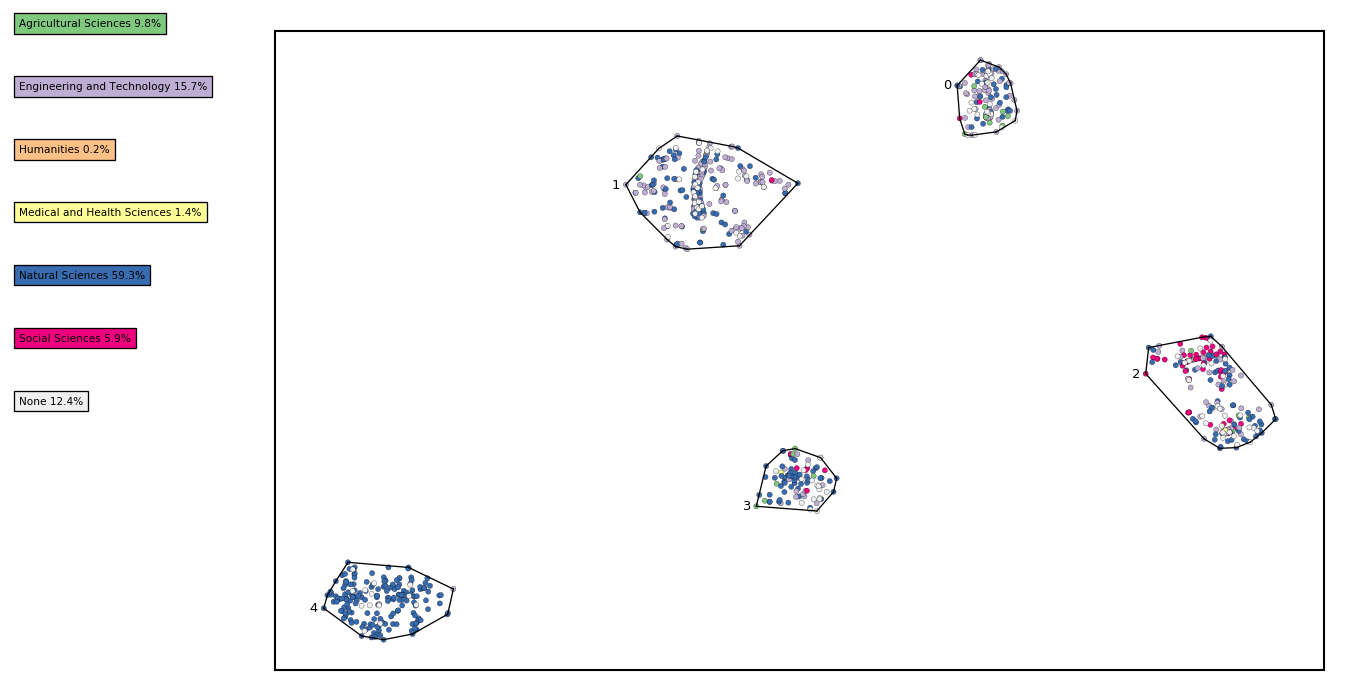

In [237]:
label_set = list(set(labels))

fig = plt.figure(dpi=188)

import matplotlib.colors as colors
import matplotlib.cm as cmx
jet = cm = plt.get_cmap('jet') 
cNorm  = colors.Normalize(vmin=min(label_set), vmax=max(label_set))
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)

df = pd.DataFrame()

colors = ['#7fc97f','#beaed4','#fdc086','#ffff99','#386cb0','#f0027f','#F0F0F0']
oecd_cats = list(Doc.objects.filter(id__in=s_docs).distinct('wc__oecd').values('wc__oecd'))
for i,c in enumerate(oecd_cats):
    c['docs'] = list(Doc.objects.filter(id__in=s_docs,wc__oecd=c['wc__oecd']).values_list('id',flat=True))
    c['color'] = colors[i]

for l in list(set(labels))[:5]:
    ind = np.argwhere(labels==l)
    cs = []
    sizes = []
    xs = []
    ys = []
    
    dids = []

    for i,did in enumerate(ind):
        x = tsne_results[did[0],0]
        y = tsne_results[did[0],1]
        col = "grey"
        for c in oecd_cats:
            if c_ind[did[0]] in c['docs']:
                col = c['color']
        cs.append(col)
        xs.append(x)
        ys.append(y)
        dids.append(c_ind[did[0]])
        
    dt = DocTopic.objects.filter(
        doc__id__in=dids,
        run_id=run_id
    ).aggregate(
        tscore=Sum('score')
    )

    dts = DocTopic.objects.filter(
        doc__id__in=dids,
        run_id=run_id
    ).values('topic__title').annotate(
        tscore=Sum('score'),
        tshare = F('tscore')/dt['tscore'],
        #cluster = l
    ).order_by('-tscore')

    rows = pd.DataFrame.from_dict(list(dts))
    rows['cluster'] = l
    df = df.append(rows)
        
    if l !=-1:
        points = np.array([(xs[i],ys[i]) for i,v in enumerate(xs)])
        hull = ConvexHull(points)
        for i, simplex in enumerate(hull.simplices):
            plt.plot(
                points[simplex, 0], 
                points[simplex, 1], 
                'k-',
                linewidth=0.5
            )
            for j in range(len(points[simplex,0])):                
                if i==0 and j==0:
                    px = points[simplex,0][j]
                    py = points[simplex,1][j]
                else:
                    if points[simplex,0][j] < px:
                        px = points[simplex,0][j]
                        py = points[simplex,1][j]                    

        plt.text(
            px-1,
            py,
            l,
            va="center",
            ha="right",
            fontsize=5
        )
        
    plt.scatter(
        xs,
        ys,
        s=4,
        #s=sizes,
        linewidth=0.1,
        c=cs,
        edgecolor='k'
    )

for i,c in enumerate(oecd_cats):
    plt.text(
        -140,
        140-i*15,
        "{} {:.1%}".format(c['wc__oecd'],len(c['docs'])/10000),
        fontsize=4,
        bbox={
            'facecolor': c['color'],
            'pad': 2,
            'lw': 0.5
        }
    )

plt.tick_params(
    axis='both',          
    which='both',      
    bottom=False,      
    top=False,  
    labelbottom=False,
    left=False,
    labelleft=False
)

In [233]:
df[(df['cluster']==0) & (df['tshare']>0.01)]

,topic__title,tscore,tshare,cluster
0,"{wast, landfil, materi}",4.769430,0.314413,0
1,"{emiss, reduct, reduc}",0.492480,0.032466,0
2,"{environment, impact, life}",0.477544,0.031481,0
3,"{energi, consumpt, renew}",0.401667,0.026479,0
4,"{gas, coal, greenhous}",0.366374,0.024152,0
5,"{process, reaction, captur}",0.359244,0.023682,0
6,"{product, primari, produc}",0.358541,0.023636,0
7,"{technolog, ccs, captur}",0.331282,0.021839,0
8,"{ghg, greenhous, mitig}",0.312032,0.020570,0
9,"{cost, price, optim}",0.311439,0.020531,0


In [241]:
np.save('../data/labels.npy',labels)
np.save('../data/c_ind.npy',c_ind)
np.save('../data/tsne_results.npy',tsne_results)
np.save('../data/s_docs.npy',s_docs)